In [1]:
# Import all the libraries needed
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
# from torch.utils.tensorboard import SummaryWriter


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import PIL
import random
import time
import os
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.1.0
Torchvision Version:  0.3.0


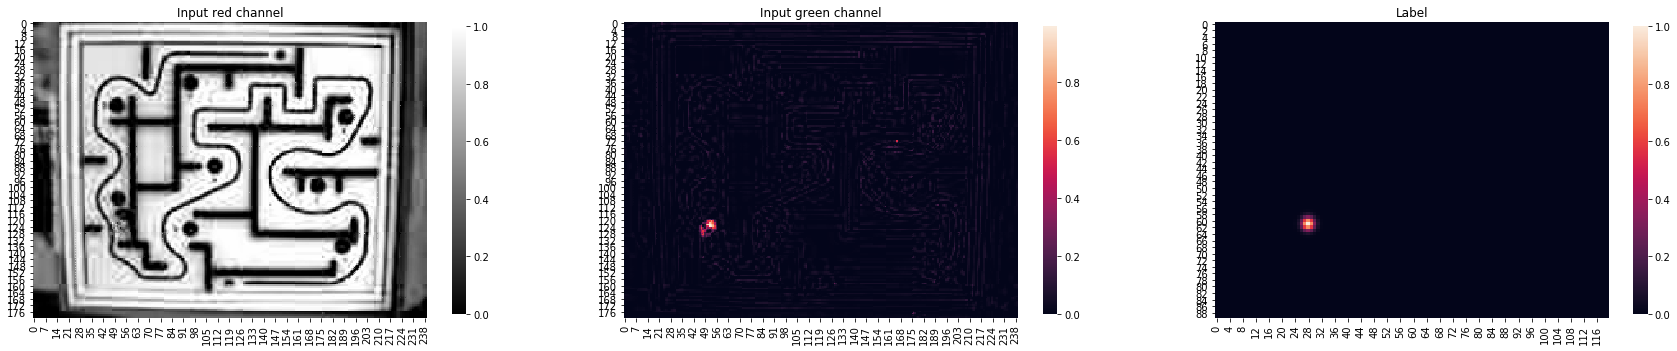

In [2]:
# Visualize the input of the CNN
fig = plt.figure(figsize = (30,30))
ax1 = fig.add_subplot(3, 3, 1)
ax1.set_title('Input red channel')
ax2 = fig.add_subplot(3, 3, 2)
ax2.set_title('Input green channel')
ax3 = fig.add_subplot(3, 3, 3)
ax3.set_title('Label')

x = np.load('Data/traindir/r_data/r_data-1900.npy')
y = np.load('Data/traindir/labels/label-1900.npy')
z = np.load('Data/traindir/g_data/g_data-1900.npy')
x = Image.fromarray(x.astype(np.uint8))
y = Image.fromarray(y.astype(np.uint8))
z = Image.fromarray(z.astype(np.uint8))

x = TF.to_tensor(x)
y = TF.to_tensor(y)
z = TF.to_tensor(z)


sns.heatmap(x[0], cmap='gray', ax=ax1, square=True, cbar_kws={'shrink': .6})
sns.heatmap(z[0], ax=ax2, square=True, cbar_kws={'shrink': .6})
sns.heatmap(y[0], ax=ax3, square=True, cbar_kws={'shrink': .6})
plt.show()

In [3]:
# writer = SummaryWriter('Tensorboard')
# train_inputs, train_labels = next(iter(dataloaders['train']))
# img_grid = torchvision.utils.make_grid(train_inputs)
# matplotlib_imshow(img_grid, one_channel=True)

In [4]:
input_width = 240
input_height = 180

output_width = 120
output_height = 90

# Tell the dataloader where to search and where to put the arrays
traindir = 'Data/traindir'
train_channels = [f'{traindir}/r_data', f'{traindir}/g_data']

valdir = 'Data/valdir'
val_channels = [f'{valdir}/r_data', f'{valdir}/g_data']

testdir = 'Data/testdir'
test_channels = [f'{testdir}/r_data', f'{testdir}/g_data']

train_inputs = []
train_labels = []

val_inputs = []
val_labels = []

test_inputs = []
test_labels = []




# Load the saved .npy arrays from the preprocessing.py file into the above arrays,
# split up the red and green channel again so that the axes match in size
def load_npy_arrays(phase):
    
    if phase == "train":
        phase_channels = train_channels
        phase_inputs = train_inputs
        phasedir = traindir
        phase_labels = train_labels
    
    elif phase == "val":
        phase_channels = val_channels
        phase_inputs = val_inputs
        phasedir = valdir
        phase_labels = val_labels
    
    elif phase == "test":
        phase_channels = test_channels
        phase_inputs = test_inputs
        phasedir = testdir
        phase_labels = test_labels
    
    else:
        print('Valueerror: please pass one of the three accepted strings("train", "val", "test")')

    for channel in phase_channels:
        path_to_channel = channel
        for file in sorted(os.listdir(channel)):
            filename = file
            if filename.endswith('.npy'):
                loaded_array = np.load(f'{path_to_channel}/{filename}')
                phase_inputs.append(loaded_array)
                continue
            else:
                continue
                
    labelfolder = f'{phasedir}/labels'
    for file in sorted(os.listdir(labelfolder)):
        filename = file
        if filename.endswith('.npy'):
            loaded_array = np.load(f'{labelfolder}/{filename}')
            phase_labels.append(loaded_array)
            continue
        else:
            continue
    print(np.shape(phase_labels))

load_npy_arrays("train")
load_npy_arrays("val")
load_npy_arrays("test")

train_inputs = np.asarray(train_inputs)
train_inputs = np.split(train_inputs, 2, axis=0)
train_inputs = np.asarray(train_inputs).transpose(1,0,2,3)
print(np.shape(train_inputs))

val_inputs = np.asarray(val_inputs)
val_inputs = np.split(val_inputs, 2, axis=0)
val_inputs = np.asarray(val_inputs).transpose(1,0,2,3)
print(np.shape(val_inputs))

test_inputs = np.asarray(test_inputs)
test_inputs = np.split(test_inputs, 2, axis=0)
test_inputs = np.asarray(test_inputs).transpose(1,0,2,3)
print(np.shape(test_inputs))

train_labels = np.asarray(train_labels)
val_labels = np.asarray(val_labels)
test_labels = np.asarray(test_labels)


# Define our own dataset creator because we want to load numpy arrays,
# but still be able to apply transformations as if it were images
class CreateDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = torch.FloatTensor(inputs)
        self.labels = torch.FloatTensor(labels)
        
    def __getitem__(self, index):
        x = self.inputs[index]
        y = self.labels[index]
        
        xred = x[0]
        xgreen = x[1]
        
        xred = Image.fromarray(xred.numpy().astype(np.uint8))
        xgreen = Image.fromarray(xgreen.numpy().astype(np.uint8))
        y = Image.fromarray(self.labels[index].numpy().astype(np.uint8))
        
        if random.random() > 0.5:
            xred = TF.hflip(xred)
            xgreen = TF.hflip(xgreen)
            y = TF.hflip(y)
            
        if random.random() > 0.5:
            xred = TF.vflip(xred)
            xgreen = TF.vflip(xgreen)
            y = TF.vflip(y)
            
        if random.random() > 0.5: 
            angle = random.randint(-180, 180)
            
            xred = TF.resize(xred, (input_height*2,input_width*2), interpolation=2)
            xgreen = TF.resize(xgreen, (input_height*2,input_width*2), interpolation=2)
            y = TF.resize(y, (output_height*2,output_width*2), interpolation=2)
            
            filler = 0.0 if xred.mode.startswith("F") else 0
            num_bands = len(xred.getbands())
            xred = TF.rotate(xred, angle)
            
            filler = 0.0 if xgreen.mode.startswith("F") else 0
            num_bands = len(xgreen.getbands())
            xgreen = TF.rotate(xgreen, angle)
            
            filler = 0.0 if y.mode.startswith("F") else 0
            num_bands = len(y.getbands())
            y = TF.rotate(y, angle)
            
            xred = TF.resize(xred, (input_height,input_width), interpolation=2)
            xgreen = TF.resize(xgreen, (input_height,input_width), interpolation=2)
            y = TF.resize(y, (output_height,output_width), interpolation=2)
        
        xred = TF.to_tensor(xred)
        xgreen = TF.to_tensor(xgreen)
        y = TF.to_tensor(y)
        
        x[0] = xred
        x[1] = xgreen
        
        return x, y

    def __len__(self):
        return len(self.inputs)

    
# Get the data, transform it
data = {
   'train':
   CreateDataset(train_inputs, train_labels),
   'val':
   CreateDataset(val_inputs, val_labels),
    'test':
   CreateDataset(test_inputs, test_labels),
}


batch_size = 1
print('Sum of all labels in a batch: ' ,batch_size*np.sum(train_labels[0]/255))

# Load Data in batches, shuffled
dataloaders = {
   'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True, drop_last=True),
   'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True, drop_last=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True, drop_last=True),
}

(1546, 90, 120)
(284, 90, 120)
(330, 90, 120)
(1546, 2, 180, 240)
(284, 2, 180, 240)
(330, 2, 180, 240)
Sum of all labels in a batch:  11.341149479456016


In [5]:
# Load in pretrained VGG16 net, extract the FCN part, delete pooling layers,
# modify first layer to recieve 2 channels, the last one to output depth 1

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(2,16,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(16),
            nn.Sigmoid())
    
        self.layer2 = nn.Sequential( 
            nn.Conv2d(16,32,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(32),
            nn.MaxPool3d((1,2,2), padding=0),
            nn.Sigmoid())
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),  
            nn.BatchNorm2d(64),
            nn.Sigmoid())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64,1,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),  
            nn.BatchNorm2d(1),
            nn.Sigmoid())

    def forward(self,x):
        x = self.layer1(x)  
        x = self.layer2(x)  
        x = self.layer3(x)  
        x = self.layer4(x)  
        return x

In [6]:
# Check if GPU is available and move the model over to GPU
if torch.cuda.is_available():
    device = torch.device("cuda: 0")
    gpu_name = torch.cuda.get_device_name()
    print(f"Running on your {gpu_name} (GPU)")
else:
    device = torch.device("cpu")
    print("Running on your CPU")

net = CNN().to(device)

Running on your GeForce 920M (GPU)


In [ ]:
# Define the training loop with loss-function and optimizer

loss_fn = nn.L1Loss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=0.001)

epochs = 15
epochs_no_improve_limit = 7

train_losses = []
val_losses = []


def train():
    epochs_no_improve = 0
    min_val_loss = np.Inf
    since = time.time()
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)
        val_loss = 0
        
        for train_inputs, train_labels in dataloaders['train']:
            optimizer.zero_grad()
            output = net(train_inputs.to(device)).reshape(batch_size, output_height, output_width)
            loss = loss_fn(output.cpu(), train_labels.cpu().reshape(batch_size, output_height, output_width))
            
#             fig = plt.figure(figsize = (32,24))
#             ax1 = fig.add_subplot(2, 2, 1)
#             ax1.set_title('Input red')
#             ax2 = fig.add_subplot(2, 2, 2)
#             ax2.set_title('Input green')
#             ax3 = fig.add_subplot(2, 2, 3)
#             ax3.set_title('Label')
#             ax4 = fig.add_subplot(2, 2, 4)
#             ax4.set_title('Output of the CNN')

#             sns.heatmap(train_inputs[0][0], cmap='gray', ax=ax1, cbar_kws={'shrink': .6})
#             sns.heatmap(train_inputs[0][1], ax=ax2, cbar_kws={'shrink': .6})
#             sns.heatmap(train_labels[0][0], ax=ax3, cbar_kws={'shrink': .6})
#             sns.heatmap(output.cpu().detach().numpy()[0], ax=ax4, cbar_kws={'shrink': .6})
#             plt.show()
            
            train_losses.append(float(loss))
            print('Training Loss: {:.4f}'.format(loss))
            loss.backward()
            optimizer.step()
        
        del train_inputs
        del train_labels
        del output
        del loss
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            for val_inputs, val_labels in dataloaders['val']:
                torch.cuda.empty_cache()
                output = net(val_inputs.to(device)).reshape(batch_size, output_height, output_width)
                loss = loss_fn(output.cpu(), val_labels.cpu().reshape(batch_size, output_height, output_width))
                val_loss += loss

            val_loss = val_loss / len(dataloaders['val'])
            val_losses.append(float(val_loss))
            print('-' * 10)
            print('Validation Loss: {:.4f}'.format(val_loss))

            if val_loss < min_val_loss:
                torch.save({'state_dict': net.state_dict()}, 'Nets/pt-labi_CNN_minloss{:.4f}.pt'.format(min_val_loss))
                epochs_no_improve = 0
                min_val_loss = val_loss
            else:
                epochs_no_improve += 1
                if epochs_no_improve == epochs_no_improve_limit:
                    print('Early stopping initiated')
                    model = torch.load('Nets/pt-labi_CNN_minloss{:.4f}.pt'.format(min_val_loss))
                    print('Best model so far has been loaded')
    print('Least validation Loss: {:4f}'.format(min_val_loss))
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Finished training')
train()

Epoch 1/15
----------
Training Loss: 5371.3135
Training Loss: 5300.5513
Training Loss: 5266.9790
Training Loss: 5241.4058
Training Loss: 5233.2808
Training Loss: 5224.2812
Training Loss: 5222.0576
Training Loss: 5216.2954
Training Loss: 5210.9546
Training Loss: 5209.0308
Training Loss: 5206.2573
Training Loss: 5199.9971
Training Loss: 5199.3633
Training Loss: 5195.6055
Training Loss: 5190.9849
Training Loss: 5190.7627
Training Loss: 5186.0112
Training Loss: 5180.8320
Training Loss: 5178.0059
Training Loss: 5176.1880
Training Loss: 5171.8071
Training Loss: 5168.5967
Training Loss: 5165.5078
Training Loss: 5162.9810
Training Loss: 5157.3525
Training Loss: 5157.7095
Training Loss: 5151.5327
Training Loss: 5149.3838
Training Loss: 5147.7114
Training Loss: 5143.2900
Training Loss: 5139.2988
Training Loss: 5138.7500
Training Loss: 5134.0376
Training Loss: 5132.4282
Training Loss: 5129.2925
Training Loss: 5124.1206
Training Loss: 5123.1807
Training Loss: 5119.6221
Training Loss: 5115.4307
Tra

Training Loss: 4275.6597
Training Loss: 4271.9595
Training Loss: 4268.5474
Training Loss: 4265.2510
Training Loss: 4262.3599
Training Loss: 4261.4146
Training Loss: 4259.3735
Training Loss: 4254.0635
Training Loss: 4251.4546
Training Loss: 4248.0659
Training Loss: 4246.8413
Training Loss: 4244.7915
Training Loss: 4240.2119
Training Loss: 4237.5967
Training Loss: 4235.9502
Training Loss: 4233.1387
Training Loss: 4231.1494
Training Loss: 4226.6973
Training Loss: 4223.7417
Training Loss: 4222.5942
Training Loss: 4216.5039
Training Loss: 4215.6670
Training Loss: 4214.3940
Training Loss: 4211.3887
Training Loss: 4205.0781
Training Loss: 4205.8862
Training Loss: 4203.5200
Training Loss: 4198.8311
Training Loss: 4194.8262
Training Loss: 4191.0962
Training Loss: 4191.8965
Training Loss: 4189.5977
Training Loss: 4187.2065
Training Loss: 4183.4814
Training Loss: 4180.8286
Training Loss: 4179.2529
Training Loss: 4175.9941
Training Loss: 4171.2900
Training Loss: 4168.9009
Training Loss: 4164.5347


Training Loss: 3426.5115
Training Loss: 3427.2886
Training Loss: 3422.5579
Training Loss: 3422.1545
Training Loss: 3418.6470
Training Loss: 3415.1335
Training Loss: 3413.5415
Training Loss: 3412.9402
Training Loss: 3410.0012
Training Loss: 3406.1248
Training Loss: 3405.1802
Training Loss: 3403.3337
Training Loss: 3399.9946
Training Loss: 3398.6377
Training Loss: 3392.5420
Training Loss: 3394.1819
Training Loss: 3391.1699
Training Loss: 3387.6216
Training Loss: 3386.8245
Training Loss: 3382.3530
Training Loss: 3379.6831
Training Loss: 3379.0349
Training Loss: 3375.9302
Training Loss: 3376.8525
Training Loss: 3369.2979
Training Loss: 3369.3701
Training Loss: 3369.0933
Training Loss: 3367.1631
Training Loss: 3363.1248
Training Loss: 3360.9199
Training Loss: 3359.8108
Training Loss: 3354.0950
Training Loss: 3353.0151
Training Loss: 3351.1543
Training Loss: 3350.3086
Training Loss: 3347.3254
Training Loss: 3343.9976
Training Loss: 3342.6428
Training Loss: 3341.9426
Training Loss: 3338.8823


Training Loss: 2738.8987
Training Loss: 2734.4722
Training Loss: 2734.9473
Training Loss: 2732.9954
Training Loss: 2727.5562
Training Loss: 2726.3870
Training Loss: 2727.5386
Training Loss: 2723.2629
Training Loss: 2721.3281
Training Loss: 2722.1379
Training Loss: 2718.9756
Training Loss: 2718.0955
Training Loss: 2713.9807
Training Loss: 2712.4978
Training Loss: 2711.1531
Training Loss: 2706.3098
Training Loss: 2709.3850
Training Loss: 2705.2939
Training Loss: 2704.8877
Training Loss: 2704.3284
Training Loss: 2702.6687
Training Loss: 2699.9609
Training Loss: 2695.1299
Training Loss: 2695.7036
Training Loss: 2692.5491
Training Loss: 2690.9409
Training Loss: 2688.5327
Training Loss: 2689.5762
Training Loss: 2685.9111
Training Loss: 2684.4136
Training Loss: 2682.7083
Training Loss: 2679.9336
Training Loss: 2678.8354
Training Loss: 2679.0981
Training Loss: 2675.5881
Training Loss: 2675.5491
Training Loss: 2673.4998
Training Loss: 2668.0632
Training Loss: 2669.6760
Training Loss: 2666.3362


Training Loss: 2205.0781
Training Loss: 2201.1169
Training Loss: 2202.4021
Training Loss: 2199.1934
Training Loss: 2196.2773
Training Loss: 2196.1047
Training Loss: 2192.5923
Training Loss: 2189.2771
Training Loss: 2190.7725
Training Loss: 2190.6064
Training Loss: 2189.5549
Training Loss: 2189.1975
Training Loss: 2182.6650
Training Loss: 2185.0354
Training Loss: 2181.5405
Training Loss: 2181.7249
Training Loss: 2181.7024
Training Loss: 2180.7576
Training Loss: 2178.8850
Training Loss: 2176.5781
Training Loss: 2176.1504
Training Loss: 2171.4500
Training Loss: 2172.6406
Training Loss: 2170.5046
Training Loss: 2167.3755
Training Loss: 2167.9082
Training Loss: 2163.9187
Training Loss: 2165.9119
Training Loss: 2160.2483
Training Loss: 2159.1958
Training Loss: 2164.7219
Training Loss: 2157.4844
Training Loss: 2160.2134
Training Loss: 2155.6934
Training Loss: 2154.5505
Training Loss: 2151.6152
Training Loss: 2153.2764
Training Loss: 2150.6582
Training Loss: 2150.1865
Training Loss: 2143.3250


Training Loss: 1794.1344
Training Loss: 1792.8280
Training Loss: 1792.0734
Training Loss: 1791.0404
Training Loss: 1789.7340
Training Loss: 1788.5283
Training Loss: 1787.7489
Training Loss: 1787.8845
Training Loss: 1787.0293
Training Loss: 1784.5706
Training Loss: 1784.6548
Training Loss: 1783.6384
Training Loss: 1781.3729
Training Loss: 1781.6685
Training Loss: 1779.2028
Training Loss: 1779.4724
Training Loss: 1776.8804
Training Loss: 1775.6765
Training Loss: 1776.3136
Training Loss: 1774.1685
Training Loss: 1774.0919
Training Loss: 1771.3965
Training Loss: 1771.9749
Training Loss: 1770.7261
Training Loss: 1768.6808
Training Loss: 1767.8635
Training Loss: 1767.8888
Training Loss: 1766.9001
Training Loss: 1764.4868
Training Loss: 1764.4590
Training Loss: 1761.9811
Training Loss: 1761.0593
Training Loss: 1761.3184
Training Loss: 1758.9769
Training Loss: 1757.8187
Training Loss: 1758.4833
Training Loss: 1757.3636
Training Loss: 1755.9822
Training Loss: 1753.7133
Training Loss: 1752.8016


In [ ]:
# Define the testing loop and output some heatmaps
# to estimate the performance of the CNN

def test():
    test_loss = 0
    with torch.no_grad():
        for test_inputs, test_labels in dataloaders['test']:
            output = net(test_inputs.to(device)).reshape(batch_size, output_height, output_width)
            loss = loss_fn(output.cpu(), test_labels[0].cpu())
            output = output[0].reshape(output_height, output_width).cpu().detach().numpy()
            test_labels = test_labels[0].reshape(output_height, output_width)
            test_loss += loss

            fig = plt.figure(figsize = (32,24))
            ax1 = fig.add_subplot(2, 2, 1)
            ax1.set_title('Output')
            ax2 = fig.add_subplot(2, 2, 2)
            ax2.set_title('Label')

            sns.heatmap(output, ax=ax1, square=True, cbar_kws={'shrink': .6})
            sns.heatmap(test_labels, ax=ax2, square=True, cbar_kws={'shrink': .6})
            plt.show()
        
        test_loss = test_loss/len(dataloaders['test'])
        print('Average test loss: ' ,test_loss.numpy())
        print('Testing completed')
test()